# DATA 608 Assignment 5: What Is The Effect Of The Earth's Temperature on Cyclonic Storms?

Historic data indicates that the occurrence and intensity of cyclonic storms (Hurricanes, Typhoons and Tornados) increases with the increased earth temperature. 

For this assignment you will need to tell this story to a non-technical audience (eg: a high-school earth science class)



In [1]:
# load dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import matplotlib.dates as dates

# Data Preparation

In [2]:
# load the data set for both land and ocean anomalies
anomalies_url = 'https://raw.githubusercontent.com/eddiexunyc/earth_temp_cyclone_data/refs/heads/main/Resources/anomalies_data.csv'
ocean_anomalies_url = 'https://raw.githubusercontent.com/eddiexunyc/earth_temp_cyclone_data/refs/heads/main/Resources/ocean_temp_anomalies.csv'
land_anomalies_url = 'https://raw.githubusercontent.com/eddiexunyc/earth_temp_cyclone_data/refs/heads/main/Resources/land_temp_anomalies.csv'

land_ocean_anomalies_data = pd.read_csv(anomalies_url)
ocean_anomalies_data = pd.read_csv(ocean_anomalies_url)
land_anomalies_data = pd.read_csv(land_anomalies_url)

# load the hurricane data set and remove uncessary columns
hur_data_url = 'https://www.nhc.noaa.gov/data/hurdat/hurdat2-1851-2023-051124.txt'
hurricane_raw_data = pd.read_csv(hur_data_url, sep = ',').reset_index()
hurricane_raw_data = hurricane_raw_data.drop(['AL011851', '            UNNAMED', '     14', 'Unnamed: 3','level_7',
                                               'level_8', 'level_9', 'level_10', 'level_11', 'level_12', 
                                              'level_13', 'level_14', 'level_15', 'level_16'], axis=1)

# load the us tornadoes data set
tornadoes_url = 'https://raw.githubusercontent.com/eddiexunyc/earth_temp_cyclone_data/refs/heads/main/Resources/us_tornadoes.csv'
tornadoes_data = pd.read_csv(tornadoes_url)

The hurricane data is sourced from NOAA Hurricane Database and is unstructured. Because of that, it needs to be transformed before loading it for data analysis and visualization. The anomalies data will be also be cleansed as well.

In [3]:
# create Saffir-Simpson Hurricane Scale function
def hurricane_scale(x):
    if 74 <= x['wind_speed'] <= 95:
        return 1
    elif 96 <= x['wind_speed'] <= 110:
        return 2
    elif 111 <= x['wind_speed'] <= 129:
        return 3
    elif 130 <= x['wind_speed'] <= 156:
        return 4
    elif x['wind_speed'] >= 157:
        return 5
    else:
        return 0

# create a dictionary and sort the data based on the storm ID and name
hurricane_raw_data_dict = hurricane_raw_data.to_dict(orient='record')
storm_id = None
storm_name = None
date_time = None
latitude = None
longtitude = None
wind_speed = None

hurricane_data = []

for data in hurricane_raw_data_dict:
    if data['level_0'].startswith('AL'):
        storm_id = data['level_0']
        storm_name = data['level_1']
    else:
        date_time = data['level_0']
        latitude = data['level_4']
        longtitude = data['level_5']
        wind_speed = data['level_6']

    hurricane_data.append({
        'storm_id': storm_id,
        'storm_name': storm_name,
        'date_time': date_time,
        'latitude': latitude,
        'longtitude': longtitude,
        'wind_speed': wind_speed
    })

# convert the dictionary back to a data frame
hurricane_data = pd.DataFrame(hurricane_data)
hurricane_data['date_time'] = pd.to_datetime(hurricane_data['date_time'], format='%Y-%m-%d')
hurricane_data['year'] = hurricane_data['date_time'].dt.year
hurricane_data['category'] = hurricane_data.apply(hurricane_scale, axis=1)

# extract the data starting from 1999 and group by
hurricane_25_data = hurricane_data[hurricane_data['year'] >= 1999]
high_risk_hurricane = hurricane_25_data[hurricane_data['category'] > 3]
high_risk_hurricane_count = high_risk_hurricane.groupby('year')['storm_id'].nunique().reset_index(name='counts')
hurricane_average_data = round(hurricane_25_data.groupby(['storm_name', 'year'])['wind_speed'].mean(), 2).reset_index().sort_values(['year'])
hurricane_average_data_count = hurricane_average_data.groupby('year').size().reset_index(name='counts')

/var/folders/h4/zjq554hs0b57vqfcrc5738wh0000gn/T/ipykernel_4416/65352773.py:17: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  hurricane_raw_data_dict = hurricane_raw_data.to_dict(orient='record')
/var/folders/h4/zjq554hs0b57vqfcrc5738wh0000gn/T/ipykernel_4416/65352773.py:54: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  high_risk_hurricane = hurricane_25_data[hurricane_data['category'] > 3]


In [ ]:
# rename columns on earth anomalies data
land_ocean_anomalies_data = land_ocean_anomalies_data.rename(columns={'Year': 'year', 'Anomaly': 'Land & Ocean Anomaly'})
ocean_anomalies_data = ocean_anomalies_data.rename(columns={'Anomaly': 'Ocean Anomaly'})
land_anomalies_data = land_anomalies_data.rename(columns={'Anomaly': 'Land Anomaly'})

# combine all temperature change
overall_temp_change = land_ocean_anomalies_data.merge(ocean_anomalies_data, how='left', on = 'year')
overall_temp_change = overall_temp_change.merge(land_anomalies_data, how='left', on = 'year')
overall_temp_change['year'] = pd.to_datetime(overall_temp_change['year'], format='%Y')
overall_temp_change

In [6]:
# tornada clean up
tornadoes_data['year'] = tornadoes_data['Date'].astype(str).str[0:4]
tornadoes_25_data = tornadoes_data[tornadoes_data['year'].astype(int) >= 1999]
tornadoes_25_data = tornadoes_25_data.drop(['Date'], axis=1)
tornadoes_25_data['year'] = tornadoes_data['year'].astype(str)
land_anomalies_data['year'] = land_anomalies_data['year'].astype(str)

tornado_temp_data = land_anomalies_data.merge(tornadoes_25_data, how = 'left', on = 'year')
tornado_temp_data['year'] = tornado_temp_data['year'].astype(int)
tornado_temp_data['Tornadoes'] = tornado_temp_data['Tornadoes'].astype(int)
tornado_temp_data

,year,Land Anomaly,Tornadoes,Fatalities
0,1999,0.89,54,0
1,2000,0.62,47,2
2,2001,0.62,84,2
3,2002,0.82,61,0
4,2003,0.95,32,0
5,2004,0.88,296,8
6,2005,0.76,133,1
7,2006,1.12,84,1
8,2007,1.11,52,0
9,2008,1.06,111,2


In [7]:
# combine hurricane and ocean anomaly data
cyclone_temp_data = high_risk_hurricane_count.merge(ocean_anomalies_data, how='left', on = 'year')


# Data Visualization

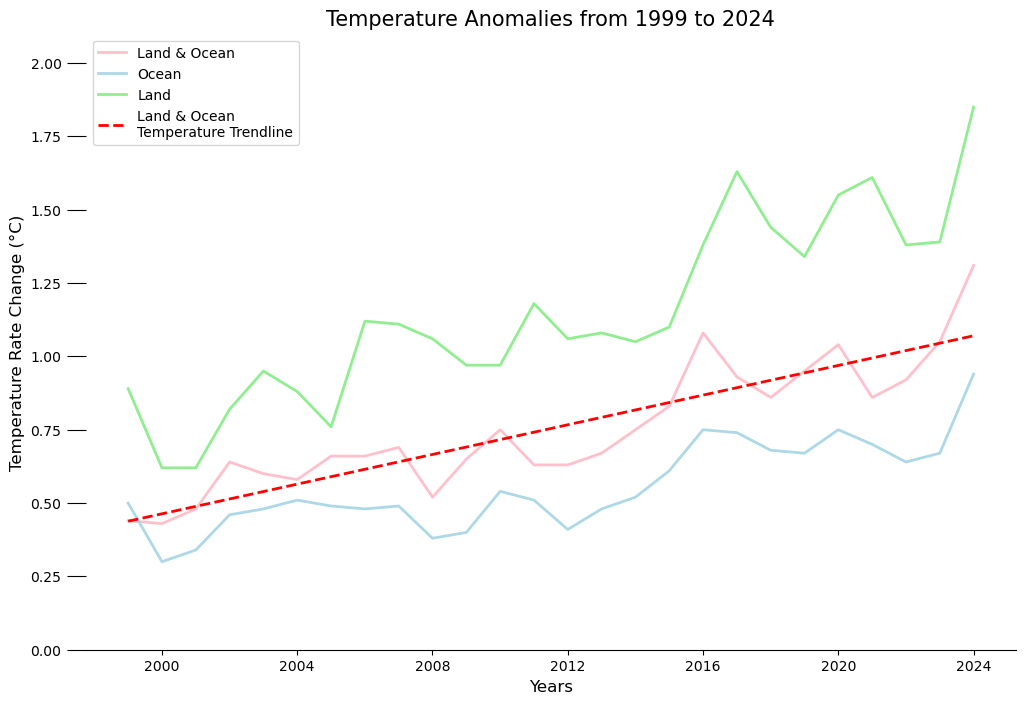

In [11]:
# overall trend on temperature anomalies
fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.plot(overall_temp_change['year'], overall_temp_change['Land & Ocean Anomaly'], color='pink', lw=2, label = 'Land & Ocean')
ax1.plot(overall_temp_change['year'], overall_temp_change['Ocean Anomaly'], color='lightblue', lw=2, label = 'Ocean')
ax1.plot(overall_temp_change['year'], overall_temp_change['Land Anomaly'], color='lightgreen', lw=2, label = 'Land')

# set the trendline
x = overall_temp_change['year']
x_num = dates.date2num(x)
trend = np.polyfit(x_num, overall_temp_change['Land & Ocean Anomaly'], 1)
fit = np.poly1d(trend)
x_fit = np.linspace(x_num.min(), x_num.max())
plt.plot(dates.num2date(x_fit), fit(x_fit), "r--", label = 'Land & Ocean \nTemperature Trendline', lw = 2)

# x and y label
ax1.set_ylabel("Temperature Rate Change (°C)", color='black', fontsize=12)
ax1.set_xlabel("Years", color='black', fontsize=12)
ax1.tick_params(axis="y", labelcolor='black', size = 14)
ax1.set_ylim(0,2.1)
ax1.legend(bbox_to_anchor=(1.3,.47),loc='lower right', frameon=False)
sns.despine(left= True, right = True)

plt.title('Temperature Anomalies from 1999 to 2024', size = 15)
plt.legend()

plt.savefig('Temperature Change in past 25 Years.png')
plt.show()

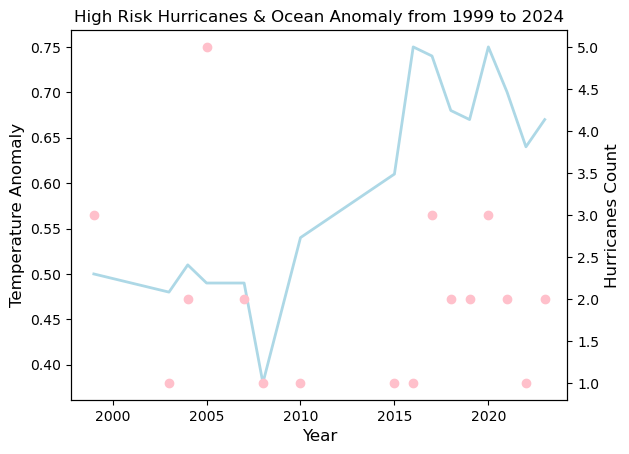

In [12]:
# line and bar graph on high hurricane count and temperature change
fig = plt.figure()
ax2 = fig.add_subplot(111)
ax2.plot(cyclone_temp_data['year'], cyclone_temp_data['Ocean Anomaly'], color='lightblue', lw=2, label = 'Temperature')
ax3 = ax2.twinx()
ax3.scatter(cyclone_temp_data['year'], cyclone_temp_data['counts'], color='pink', label = 'Hurricane')
plt.title('High Risk Hurricanes & Ocean Anomaly from 1999 to 2024', size = 12)
ax1.grid()

# customize both x and y labels
ax2.set_xlabel('Year', size = 12)
ax2.set_ylabel('Temperature Anomaly', size = 12)
ax3.set_ylabel('Hurricanes Count', size = 12)

plt.savefig('Correlation between Ocean Anomaly and High Risk Hurricanes.png')
plt.show()

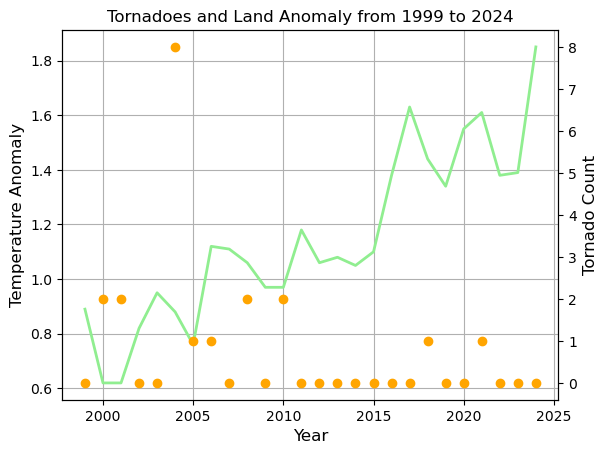

In [13]:
# tornado plot
fig = plt.figure()
ax4 = fig.add_subplot(111)
ax4.plot(tornado_temp_data['year'], tornado_temp_data['Land Anomaly'], color='lightgreen', lw=2, label = 'Temperature')
ax5 = ax4.twinx()
ax5.scatter(tornado_temp_data['year'], tornado_temp_data['Fatalities'], color='orange', label = 'Tornadoes Fatalities')
plt.title('Tornadoes and Land Anomaly from 1999 to 2024', size = 12)
ax4.grid()

# customize both x and y labels
ax4.set_xlabel('Year', size = 12, )
ax4.set_ylabel('Temperature Anomaly', size = 12)
ax5.set_ylabel('Tornado Count', size = 12)

plt.savefig('Correlation between Land Anomaly and Tornadoes Fatalities.png')
plt.show()